<a href="https://colab.research.google.com/github/job-moses/FashionProductClassifier/blob/main/FashionProductClassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

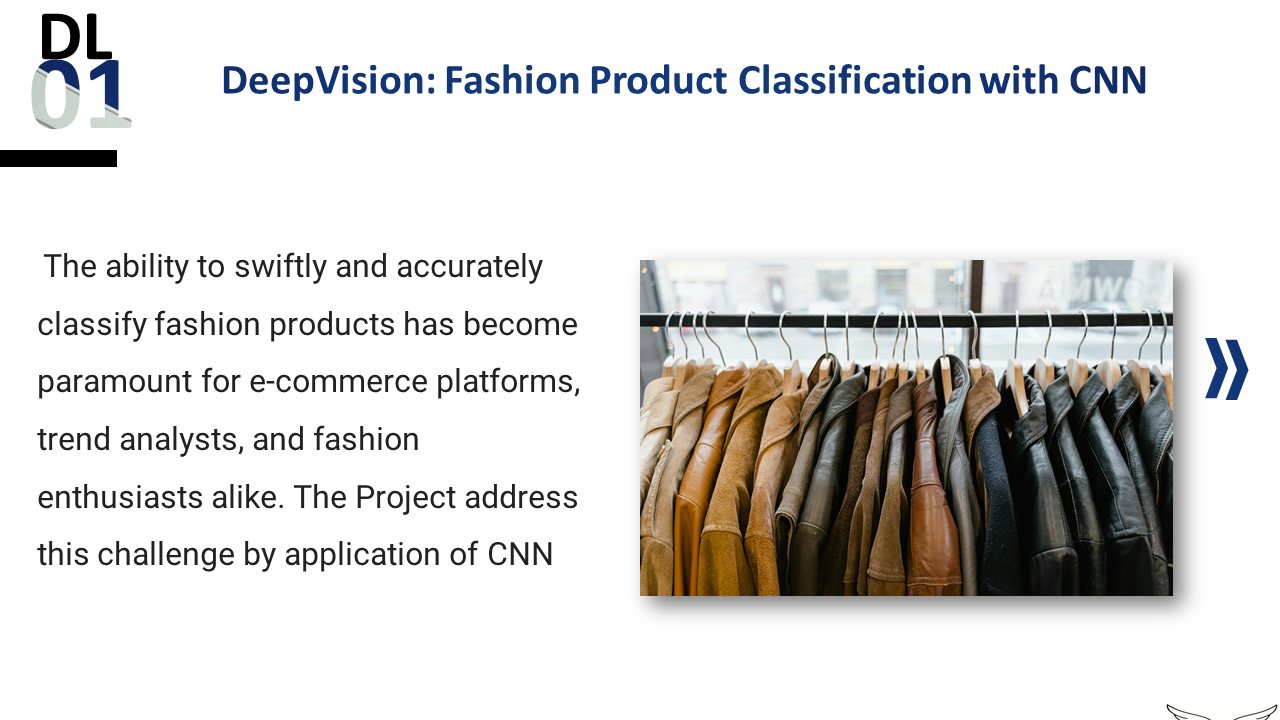









The dataset used to in this project is a kaggle dataset available [here](https://www.kaggle.com/paramaggarwal/fashion-product-images-small'). The dataset was downloades via opendataset library using my kaggle API

In [ ]:
!pip install opendatasets

In [2]:
import opendatasets as od
od.download('https://www.kaggle.com/paramaggarwal/fashion-product-images-small')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: mosesubehjob
Your Kaggle Key: ··········


100%|██████████| 565M/565M [00:05<00:00, 112MB/s]


As we can see, the data has been downloaded now let navigate into the folder

In [3]:
%cd fashion-product-images-small

/content/fashion-product-images-small


In [4]:
%ls #list files in the folder

images/  myntradataset/  styles.csv


There are three files in the folder, but we are interested in the **images** folder and **styles.css** file. The fashion images in the image folder  wil use to train the model  while styles.css file contains information about each of the images, here i will read the styles.css file but only choose the **id**  column and **masterCategory** column. I want to classify the fashion product base on the class in the masterCategory(target).

In [6]:
import pandas as pd #import library for data manipulation


In [7]:
df = pd.read_csv('styles.csv', usecols= ['id','masterCategory']) #reading styles.csv file

In [8]:
df.head() #first five rows of dataframe

,id,masterCategory
0,15970,Apparel
1,39386,Apparel
2,59263,Accessories
3,21379,Apparel
4,53759,Apparel


Since the images are in **.jpg** extension, i will create a new column by  concating the the **id** column with with .jpg extension for easy augumentation and preprocesing

In [9]:
 df['images'] = df['id'].astype('str') +'.jpg'

In [13]:
df = df.sample( frac = 1) #shuffle the images to have them mixed

In [14]:
df.sample(5)

,id,masterCategory,images
11245,36067,Accessories,36067.jpg
26386,5668,Apparel,5668.jpg
14805,58822,Accessories,58822.jpg
42410,51010,Apparel,51010.jpg
34227,9932,Apparel,9932.jpg


## Image Preprocessing with ImageDataGenerator
The ImageDataGenerator class is part of the tensorflow.keras.preprocessing.image module. It is used for real-time data augmentation and preprocessing of image data.


In [15]:
# importing library for image preprocessing
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [16]:
#define the ImageDataGenerator Object
image_genarator= ImageDataGenerator( validation_split=0.2)
batch_size = 256

In [18]:
#define training generator
train_gen = image_genarator.flow_from_dataframe(
    dataframe = df,
    x_col = 'images',
    y_col = 'masterCategory',
    target_size = (60,80),
    batch_size = batch_size,
    directory = 'images',
    subset = 'training'

)
#define test or validation generator
test_gen = image_genarator.flow_from_dataframe(
    dataframe= df,
    x_col = 'images',
    y_col = 'masterCategory',
    target_size = (60,80),
    batch_size = batch_size,
    directory = 'images',
    subset = 'validation'

)
train_gen.class_indices

Found 35553 validated image filenames belonging to 7 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1137: UserWarning: Found 5 invalid image filename(s) in x_col="images". These filename(s) will be ignored.
  warnings.warn(


Found 8888 validated image filenames belonging to 7 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1137: UserWarning: Found 5 invalid image filename(s) in x_col="images". These filename(s) will be ignored.
  warnings.warn(


{'Accessories': 0,
 'Apparel': 1,
 'Footwear': 2,
 'Free Items': 3,
 'Home': 4,
 'Personal Care': 5,
 'Sporting Goods': 6}

As we can see there are seven **7** classes of fashion product that we want to build the model on

**Model Building**

In [19]:
import tensorflow as tf
from tensorflow.keras import layers, models

In [20]:
model = models.Sequential([
    layers.Conv2D(32 , (3,3),activation = 'relu', input_shape = (60,80,3)),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64,(3,3), activation = 'relu'),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(128,(3,3) , activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dropout(0.5),
    layers.Dense(256, activation = 'relu'),
    layers.Dropout(0.5),
    layers.Dense(7, activation = 'softmax')

])

model.compile( optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [ ]:
from math import ceil
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Define callbacks to altomatically save the optimal parameter for our model,this model will be save as best_model in our file directory
early_stopping = EarlyStopping( patience=3, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True)

# fit model on train and validation data
model_history = model.fit_generator(
    generator = train_gen,
    steps_per_epoch = ceil( 0.8 * (df.shape[0]/batch_size)),
    validation_data = test_gen,
    validation_steps = ceil(0.2 * (df.shape[0]/batch_size)),
    epochs = 10,
    verbose = 1,
    callbacks=[early_stopping, model_checkpoint]
)


## Model Evaluation

In [22]:
#load best model from file directory for evaluation and prediction
model = models.load_model('best_model.h5')

here i evaluted the model on test data which was define earlier in the preprocessing stage

In [ ]:
loss, model_accuracy = model.evaluate_generator(test_gen,  steps=ceil(0.2 * (df.size / batch_size)))

In [25]:
print(model_accuracy *100)

97.3784863948822


as we can see the model has 97.378% accurary on the test set

In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 58, 78, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 29, 39, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 27, 37, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 13, 18, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 11, 16, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 5, 8, 128)         0

**Model Prediction**

now our model is ready, let use it to predict a new image, I will be use the first image in our dataset for prediction

In [27]:
import matplotlib.pyplot as plt
import numpy as np

In [28]:
df.head()

,id,masterCategory,images
26986,28039,Apparel,28039.jpg
29183,49746,Accessories,49746.jpg
18471,12372,Apparel,12372.jpg
25102,1651,Apparel,1651.jpg
18646,15168,Apparel,15168.jpg


In [ ]:
df.values[1,2]

'56306.jpg'

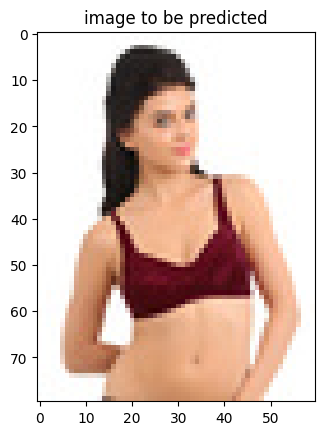

In [29]:
plt.title('image to be predicted')
plt.imshow(plt.imread('images/56306.jpg'))

as we can see the first image is an **Apparel** let load this image and see if the model will be able to recognize this image as an apparel

In [30]:

from keras.preprocessing import image
new_image = image.load_img('images/56306.jpg',target_size=(60,80))
test_image = image.img_to_array(new_image)
test_image = np.expand_dims(test_image, axis = 0)
pred_result = model.predict(test_image)
val = np.argmax(pred_result)
my_dict = train_gen.class_indices
key_list = list(my_dict.keys())
val_list = list(my_dict.values())
print(key_list[val])

1/1 [==============================] - 0s 127ms/step
Apparel


Waw,the model recogize the image as an apparel, our model is ready for fashion product classification, Moving forward, we will explore aspects such as model testing, validation, documentation, deployment planning, monitoring, maintenance, security considerations, and communication.

in conclusion,The aim of the project to utilize deep learning model such as convolutional neural network to classify fashion image product as been achieved.
The model was save for futher fashion product prediction.